<a href="https://colab.research.google.com/github/valenciajaime/MN2022_colabs/blob/main/Nuevos/MN2022_1_ODE_ajusteParametros_MJv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada Presentación Clase

**Nombres:** 

Esteban Velilla H.

Jaime A. Valencia V.


**Email:**

esteban.velilla@udea.edu.co

jalejandro.valencia@udea.edu.co


**Curso:**
Métodos numéricos 2022-1

**Fecha:**
Jueves 2022-ago-25

# Descripción

**Objetivos**

Presentación de la metodologia de ajuste de parametros en una ecuacion diferencial ordinario. Ejemplo del caso de circuito serie RLC. Se usa la funcion minimize() de scipy.optimization.


**Desarrollo**



1.   Solucion de EDO usando odeint()
2.   Programacion funcion de Error
3.   Optimizacion de parametros



La imagen muestra la metodologia a seguir para realizar el ajuste de parametros.

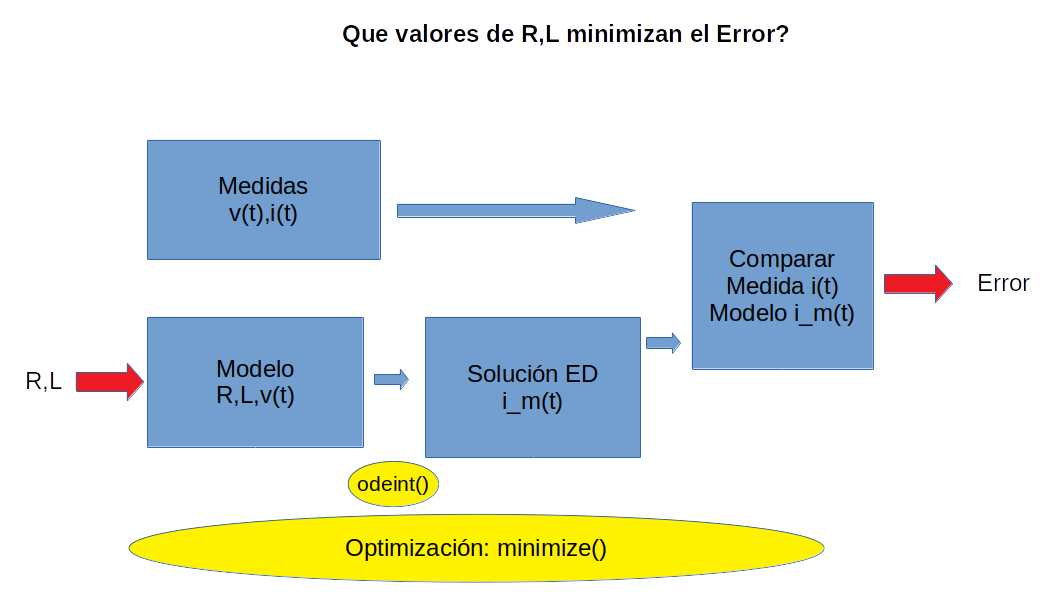

# Modulos principales

Importacion de modulo principales de trabajo en Metodos Numericos.

In [ ]:
import pylab as plt
import matplotlib
import numpy as np
import scipy as SC
import sympy as SP

Observacion de las versiones de los modulos importados.

In [ ]:
print("Version numpy: ",np.__version__)
print("Version Matplotlib: ",matplotlib.__version__)
print("Version scipy: ", SC.__version__)
print("Version sympy: ",  SP.__version__)

Version numpy:  1.21.6
Version Matplotlib:  3.2.2
Version scipy:  1.4.1
Version sympy:  1.7.1


# Solucion de EDO usando odeint()

## programacion funcion ode

In [1]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint #funcion para solucion EDO

##funcion de la ecuacion diferencia
def RLCserie(Z, t, R = 400, L = 0.7, C = 1e-6, v = lambda x:100 ):
    """Z: funcion vectorial dependiente de t
       t: variable independiente
       Funcion para solucion del circuito
       serie RLC
       vf = R i + L di/dt + vc
       ic = C dvc/dt
       
    """
    # voltaje en voltios
    # R en ohmios
    # L en Henrios
    # C en Faradios

    vf = v(t)
     
    Is = Z[0] #corriente del circuito
    Vc = Z[1] #voltaje en condensador
    di = (1/L)*(vf - R*Is - Vc)
    dvc = (1/C)*Is
    return [di, dvc]



## Solucion EDO

In [51]:
#Definir parametros
R=40
L=0.5
C=10e-6
V_in = lambda x:100

#definir condicion inicial
Io = 0.0
Vco= 0.0
print('Corriente, Vc inicial (cir RLC): ', Io,Vco)

##definir rango de solucion

t_inicial = 0
t_final= 0.05
T = np.linspace(t_inicial, t_final, 200)

print('Solucion entre ',t_inicial,' y ',t_final, 'segundos')

y_volt=[]
for q in T:
  y_volt.append(V_in(q))
##Solucionar la ED
y_sol = odeint(RLCserie, [Io,Vco], T,(R,L,C, V_in))##f(i,t),Condic inic, tiempo,argumetos

y_cor = y_sol[:,0]
print("Len Lista solucion y_cor ",len(y_sol))


Corriente, Vc inicial (cir RLC):  0.0 0.0
Solucion entre  0  y  0.05 segundos
Len Lista solucion y_cor  200


# Lectura de datos(rev 2022-ago-25)

In [44]:
##Lectura de datos
#Funcion de lectura
def Leer_ADF01(fnombre):
    """fnombre: str nombre de archivo
       Lectura de datos de archivos ADF
       
       retorna un numpy.array con los datos numericos de las
       columnas y los nombres de las columnas.
       Numero de filas== columnas archivo
       Lista de str con nombre de las columnas

    """
    Datos = open(fnombre,"r")
    Datos.readline() #linea de informacion del archivo
    heads = Datos.readline() #Linea de nombre de columnas
    Titulos = heads.strip().split(" ")#separacion nombre de columnas
    Nc = len(Titulos) #numero de columnas

    Valores = []
    for q in Titulos:
      Valores.append([])##abre lista por cada columna
      
    for q in Datos:
      a= q.strip().split('\t')
      for k in range(Nc):
        Valores[k].append(float(a[k]))
    Datos.close()
    Valores = np.array(Valores)
        
    return Valores,Titulos

Datos, etiq = Leer_ADF01("Problema2_MN20221_WV_P2.adf")
print("Numero datos: ",Datos.shape)

Numero datos:  (3, 1001)


In [ ]:
##REEMPLAZO DE DATOS#######
##si son muchos datos se debe reducir el tamaño
## caso de archivo Problema1_MN20221_MJ_P2.adf
N_init=0
N_fin = 1000
T = Datos[0,N_init:N_fin]
y_volt = Datos[1,N_init:N_fin]
y_cor = Datos[2,N_init:N_fin]

#Grafico (Datos leidos)

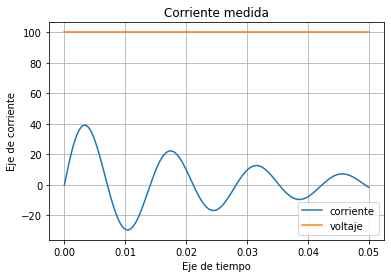

In [52]:

plt.plot(T, 100*y_cor,T,y_volt)#,T,y_sol[:,1])
plt.title('Corriente medida')
plt.xlabel('Eje de tiempo')
plt.ylabel('Eje de corriente')
plt.legend( ("corriente","voltaje","Vc") )
plt.grid(True)
plt.show()

# Problema de optimizacion

Paso1. Crear funcion de error.

Paso2. Minimizar la funcion de error.


Caso sin restriccion
[minimize()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

## Programacion funcion Error

In [30]:
##funcion Error que calcula la diferencia
## entre los datos y el modelo
## variable : R, L, C
## datos entrada: v(t), i(t)
## Calculo: error cuadratico promedio

def F_error_edo02(X, D_tiempo, D_voltios, D_amps):
    """X = [R,L,C] en Ohms y Henrios
       D_tiempo: lista de instantes de tiempo
       D_voltios: Lista de valores de voltaje(t) medidos
       D_amps: Lista de valores de corriente(t) medidos.
       La funcion calcula el error cuadratico medio entre
       el resultado de la solucion de la ecuacion diferencia
       con los parametros R, L , C y los respectivos valores 
       de la corriente medidos.
    """
    R_in, L_in, C_in = X #parametros del circuito que entran
    Io = D_amps[0] # se asume el primer dato del vector de corriente 
    Vco = 0.0         ###asumido      #  medido
    V_fuente = lambda xx: np.interp(xx,D_tiempo,D_voltios)

    S_modelo = odeint(RLCserie, [Io,Vco], D_tiempo,(R_in,L_in,C_in,V_fuente))#Solucion EDO
    
    Suma=0
    NN = len(S_modelo)
    for q in range(NN):
        ei = (S_modelo[q,0]-D_amps[q])**2
        Suma = Suma + ei
    error = Suma/NN## suma error cuadratico medio
    
    return error


In [54]:
#Evaluando la funcion de error
F_error_edo02([4,0.7,1e-6], T, y_volt, y_cor)

0.030576874149098852

## Comparacion grafica

In [36]:
##funcion Error que calcula la diferencia
## entre los datos y el modelo
## variable : R, L y C
## datos entrada: v(t), i(t)
## Calculo: error cuadratico promedio

def F_Show_error_edo02(X, D_tiempo, D_voltios, D_amps):
    """X = [R,L,C] en Ohms y Henrios
       D_tiempo: lista de instantes de tiempo
       D_voltios: Lista de valores de voltaje(t) medidos
       D_amps: Lista de valores de corriente(t) medidos.
       La funcion calcula el error cuadratico medio entre
       el resultado de la solucion de la ecuacion diferencia
       con los parametros R, L, C y los respectivos valores 
       de la corriente medidos.
    """
    R_in, L_in , C_in= X #parametros del circuito que entran
    Io = D_amps[0] # se asume el primer dato del vector de corriente 
    Vco = 0.0               #  medido
    V_fuente = lambda xx: np.interp(xx,D_tiempo,D_voltios)

    S_modelo = odeint(RLCserie, [Io,Vco], D_tiempo,(R_in,L_in,C_in,V_fuente))#Solucion EDO
    
    Suma=0
    NN = len(S_modelo)
    for q in range(NN):
        ei = (S_modelo[q,0]-D_amps[q])**2
        Suma = Suma + ei
    error = Suma/NN
    
    print("Error Cuadratico Medio= ",error)
    plt.plot(D_tiempo,D_amps,"ro")
    plt.plot(D_tiempo,S_modelo[:,0],"b*-")
    plt.legend(["Datos","Modelo"])
    plt.show()
    return error


Error Cuadratico Medio=  0.025156343874123827


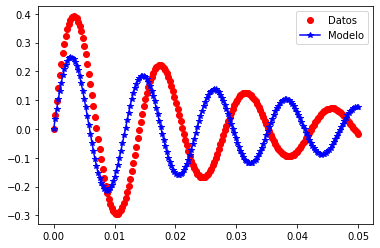

0.025156343874123827

In [60]:
F_Show_error_edo02([35,0.7,5e-6], T, y_volt, y_cor)

##Funcion minimize

In [61]:
from scipy.optimize import minimize

## aplicando un funcion de optimizacion
X0 = [1, 0.1, 1e-6] #vector inicial de busqueda
res = minimize(F_error_edo02,X0,args=(T, y_volt, y_cor),
               method="Powell"),# method='Nelder-Mead')


print("Valores R,L,C: ",res[0].x)
print("Error minimo: ",res[0].fun)



Valores R,L,C:  [4.e+01 5.e-01 1.e-05]
Error minimo:  7.025139567207853e-23


Error Cuadratico Medio=  7.025139567207853e-23


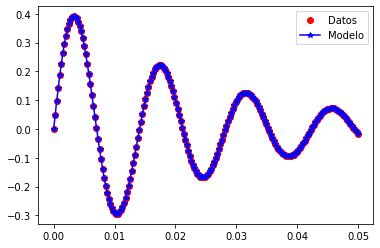

7.025139567207853e-23

In [62]:
##Validacion resultados
F_Show_error_edo02(res[0].x, T, y_volt, y_cor)

# Resultados y conclusiones

**Conclusiones:**



**Resultados:**

**Referencias:**



*Libros*

[Numerical Computing with MATLAB
Copyright 2004, Cleve Moler. Introd.](https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/intro.pdf)

[Burde & Faires](https://udeaeduco.sharepoint.com/:b:/s/MtodosNumricos_2022-1/EQd1_32TgMhCh8MBU0FqxpIBSIjxSMEJKAcVIVyvYZHSng?e=nrWw8z)

[Chapra & Canale](https://udeaeduco.sharepoint.com/:b:/s/MtodosNumricos_2022-1/EZgs5MpMDKtLpAZlwGEmn9oB3FvpAGncvlnWPcZ9wRNhIg?e=fPcsyf)





[scipy-interpolate 1.8.1](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html#)  [1.4.1](https://docs.scipy.org/doc/scipy-1.4.1/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)

[2017-marzo-15 Prezi](http://numericalmethodsie20152udea.blogspot.com/2017/03/interpolacion-ajuste-y-procesamieto-de.html)

[Guia Burden y Chapra](http://numericalmethodsie20152udea.blogspot.com/2017/03/documentacion-interpolacion-y-ajuste.html)

[2016-sep-14](http://numericalmethodsie20152udea.blogspot.com/2016/09/ajuste-de-funcion-no-lineal.html)

[2016-sep-7](http://numericalmethodsie20152udea.blogspot.com/2016/09/interpolacion-y-ajuste-de-datos.html)